In [1]:
#Import all the libraries
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,LSTM
from keras.models import Sequential
from keras.losses import mean_squared_error
from keras.backend import sign

In [5]:
#Read the data
fpath='archive/AEP_hourly.csv'
df=pd.read_csv('archive/AEP_hourly.csv')
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [6]:
# change index column from numbers 0, 1, 2.. to date&time information
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [7]:
# check missing data in file
df.isna().sum()

AEP_MW    0
dtype: int64

In [8]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['AEP_MW']=scaler.fit_transform(df['AEP_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(121273, 1)

In [9]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(0, len(stock)-seq_len, seq_len+1):
        X_train.append(stock.iloc[i: i+seq_len, 0])
        y_train.append(stock.iloc[i+seq_len, 0])
        
    #last 1000 days are going to be used in test
    X_test = X_train[4053:]             
    y_test = y_train[4053:]
    
    #first 4053 days are going to be used in training
    X_train = X_train[:4053]           
    y_train = y_train[:4053]
    
    # convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (4053, seq_len, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

#create train, test data
seq_len = 23 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df_norm, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (4053, 23, 1)
y_train.shape =  (4053,)
X_test.shape =  (1000, 23, 1)
y_test.shape =  (1000,)


In [10]:
# build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(23,activation="tanh", input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))
lstm_model.summary()
# train LSTM model
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 23)                2300      
_________________________________________________________________
dropout (Dropout)            (None, 23)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 24        
Total params: 2,324
Trainable params: 2,324
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
127/127 [==============================] - 2s 5ms/step - loss: 0.0355
Epoch 2/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0120
Epoch 3/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0091
Epoch 4/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0061
Epoch 5/10
127/127 [==============================] - 1s 5ms

In [11]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.9530821780028776


In [13]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

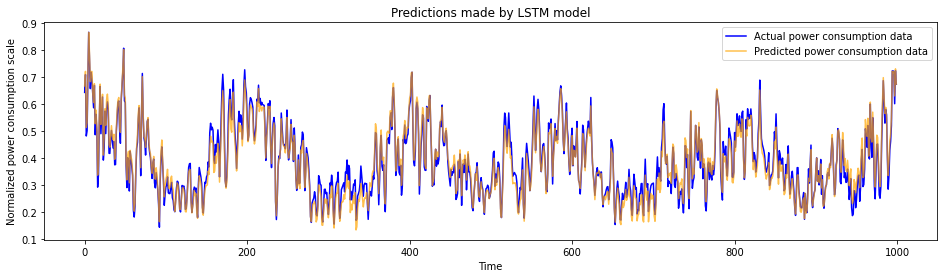

In [14]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

In [15]:
print("prediction ", lstm_predictions[:10], "\n real values ", y_test[:10])

prediction  [[0.6660858 ]
 [0.7200151 ]
 [0.5121007 ]
 [0.5297856 ]
 [0.7160529 ]
 [0.8643659 ]
 [0.7818029 ]
 [0.68183714]
 [0.71928245]
 [0.71967727]] 
 real values  [0.64223656 0.70820405 0.48088619 0.50018617 0.70212238 0.86490009
 0.7600844  0.65619958 0.71683009 0.6853047 ]


In [16]:
import math
lstm_predictions = lstm_predictions.reshape((lstm_predictions.shape[0]))
math.sqrt(mean_squared_error(y_test, lstm_predictions))

0.027611950915066207

In [17]:
#Applying Adversarial Attack


In [18]:
#FGSM

In [19]:
def fgsm_attack(data, epsilon, loss):
    # Collect the element-wise sign of the data gradient
    data_gradient = np.gradient(loss)
    sign_data_gradient = sign(data_gradient[0])
    sign_data_gradient = np.reshape(sign_data_gradient, (1000, 23, 1))
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_data = data + epsilon*sign_data_gradient
    # Return the perturbed image
    return perturbed_data

In [20]:
adversarial = fgsm_attack(X_test, 0.1, mean_squared_error(X_test, y_test))

In [21]:
adversarial_prediction = lstm_model.predict(adversarial)
adversarial_score = r2_score(y_test, adversarial_prediction)
print(adversarial_score)

0.46665423884330837


prediction  [[0.8102631 ]
 [0.62566215]
 [0.42993563]
 [0.61813706]
 [0.8079677 ]
 [0.9593174 ]
 [0.68928075]
 [0.52840275]
 [0.87013906]
 [0.62883645]] 
 real values  [0.64223656 0.70820405 0.48088619 0.50018617 0.70212238 0.86490009
 0.7600844  0.65619958 0.71683009 0.6853047 ]


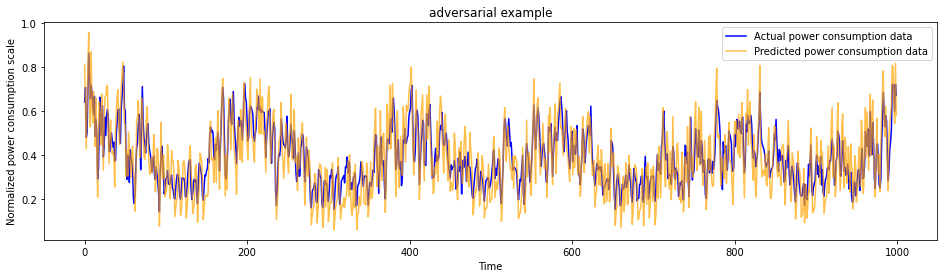

actual values  [[[0.51632121]
  [0.47648008]
  [0.62380539]
  [0.6175996 ]
  [0.61611021]
  [0.62777709]
  [0.65049026]
  [0.70659054]
  [0.77845352]
  [0.80848951]
  [0.8020355 ]
  [0.76840015]
  [0.72229118]
  [0.68741467]
  [0.65185553]
  [0.63156262]
  [0.61890282]
  [0.5934591 ]
  [0.59383145]
  [0.61381407]
  [0.6602954 ]
  [0.68052625]
  [0.67010053]]] 
 adversarial data values  [[[0.61632121]
  [0.57648008]
  [0.52380539]
  [0.5175996 ]
  [0.51611021]
  [0.52777709]
  [0.55049026]
  [0.60659054]
  [0.67845352]
  [0.70848951]
  [0.7020355 ]
  [0.66840015]
  [0.62229118]
  [0.58741467]
  [0.55185553]
  [0.53156262]
  [0.51890282]
  [0.4934591 ]
  [0.49383145]
  [0.51381407]
  [0.7602954 ]
  [0.78052625]
  [0.77010053]]]


In [22]:
#print prediction values and plot them
#print the data values
print("prediction ", adversarial_prediction[:10], "\n real values ", y_test[:10])
plot_predictions(y_test, adversarial_prediction, "adversarial example")
print("actual values ", X_test[:1], "\n adversarial data values ", adversarial[:1])

In [23]:
###Applying FGSM attack through Tensor Form
print(X_test. shape, y_test.shape, lstm_predictions.shape)


(1000, 23, 1) (1000,) (1000,)


In [24]:
#Applying a attack
#Converting data to tensors
X_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(X_tf)
    lossFunction = mean_squared_error(X_tf, lstm_predictions)
gradientFunction = tape.gradient(lossFunction, X_tf)
signed_grad = tf.sign(gradientFunction)
perturbed_data = X_test + 0.1 * signed_grad
X_perturbed = perturbed_data.numpy()

In [27]:
perturbed_predictions = lstm_model.predict(X_perturbed)
perturbed_score = r2_score(y_test, perturbed_predictions)
print("R^2 Score of LSTM model = ", perturbed_score)

R^2 Score of LSTM model =  0.4687632876045684


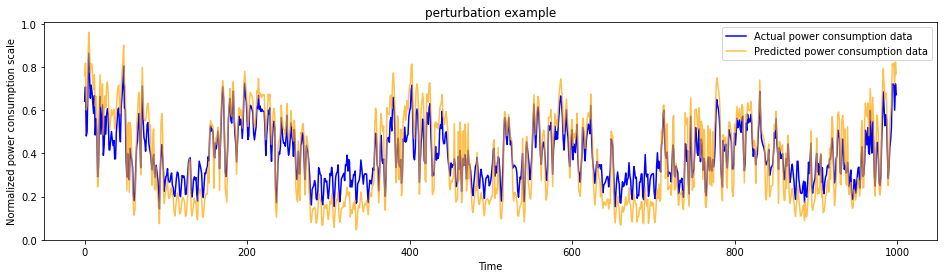

actual values  [[[0.51632121]
  [0.47648008]
  [0.62380539]
  [0.6175996 ]
  [0.61611021]
  [0.62777709]
  [0.65049026]
  [0.70659054]
  [0.77845352]
  [0.80848951]
  [0.8020355 ]
  [0.76840015]
  [0.72229118]
  [0.68741467]
  [0.65185553]
  [0.63156262]
  [0.61890282]
  [0.5934591 ]
  [0.59383145]
  [0.61381407]
  [0.6602954 ]
  [0.68052625]
  [0.67010053]]] 
 perturbed data values  [[[0.6163212 ]
  [0.5764801 ]
  [0.7238054 ]
  [0.71759963]
  [0.7161102 ]
  [0.7277771 ]
  [0.7504903 ]
  [0.80659056]
  [0.87845355]
  [0.9084895 ]
  [0.90203553]
  [0.86840016]
  [0.8222912 ]
  [0.78741467]
  [0.75185555]
  [0.7315626 ]
  [0.7189028 ]
  [0.69345915]
  [0.6938315 ]
  [0.7138141 ]
  [0.7602954 ]
  [0.7805263 ]
  [0.77010053]]]


In [28]:
plot_predictions(y_test, perturbed_predictions, "perturbation example")
print("actual values ", X_test[:1], "\n perturbed data values ", X_perturbed[:1])